In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

In [2]:
df = pd.read_csv('mysavefile.csv')

In [3]:
df.head()

,Unnamed: 0,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
0,1,3.0,<2,stallion,78,90,90,77,NaN
1,2,2.5,<2,stallion,91,97,94,100,NaN
2,3,1.5,<2,stallion,74,93,95,74,NaN
3,4,3.0,<2,female,87,109,96,116,NaN
4,5,2.5,<2,female,79,98,91,91,NaN


In [4]:
weights = list(df['Weight'])
weights.sort()
print(weights[:5])

[27, 65, 71, 72, 74]


In [5]:
#Assume donkey with weight 27 kilos 
df[df['Weight']==27]

,Unnamed: 0,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
8,9,3.0,<2,stallion,46,66,71,27,NaN


In [6]:
df[df['BCS']==1.0]

,Unnamed: 0,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
445,446,1.0,>20,female,97,109,102,115,NaN


In [7]:
df[df['BCS']==4.5]

,Unnamed: 0,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
291,292,4.5,10-15,female,107,130,106,227,NaN


In [8]:
#Remove outliers
df = df.drop([8,291,445])

In [9]:
df = df.sort_values('Weight', ignore_index = True)

In [10]:
train = df[df.index % 5 != 4]  
test = df[df.index % 5 == 4]

In [11]:
#Get most populous sample
train = train[train['BCS'] == 3.0]
train = train[train['Age'] != '<2']
train = train[train['Age'] != '2-5']

In [12]:
#Save training data
train.to_csv('train.csv')

In [13]:
train['log_length'] = np.log(train['Length'])
train['log_girth'] = np.log(train['Girth'])
train['transformed_Weight'] = 2*(np.sqrt(train['Weight'])-1)

In [14]:
result = sm.ols(formula="transformed_Weight ~ log_length + log_girth", data=train).fit()
print(result.params)
b0 = result.params['Intercept']
b1 = result.params['log_length']
b2 = result.params['log_girth']

Intercept    -103.552621
log_length      7.079724
log_girth      19.799255
dtype: float64


In [15]:
#Note that the values obtained are significantly different
b0_given = -107
b1_given = 19.91
b2_given = 7.712

In [16]:
def f(girth, b0, b1):
    return b0 + b1*np.log(girth)

In [17]:
def g(length, b2):
    return b2*np.log(length)

In [18]:
def h_inverse(h):
    return ((h/2)+1)**2

In [19]:
#Adjusted values
bcs_dict = {1.5: -10, 2.0: -6, 2.5: -5, 3.0: 0, 3.5: 6, 4.0: 14}
age_dict = {'<2': -8, '2-5': -4, '5-10': 0, '10-15': 0, '15-20': 0, '>20': 0}

In [20]:
#Get prediction based on attributes
def get_weight(bcs, age, length, girth, b0, b1, b2):
    bcs_change = bcs_dict[bcs]
    age_change = age_dict[age]
    return h_inverse(f(girth, b0, b1) + g(length, b2))+ bcs_change + age_change

In [21]:
#Reproducing example given, we note significant differences in predictions using beta values we obtained
print(get_weight(3, '5-10', 103, 122, b0_given, b1_given, b2_given))
print(get_weight(3, '5-10', 103, 122, b0, b1, b2))

174.12239409550034
146.68479519957538


In [22]:
#We shall continue with the beta values they provided

In [23]:
test.head()

,Unnamed: 0,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
4,45,3.0,<2,female,80,94,89,75,NaN
9,33,2.5,<2,stallion,72,97,94,89,NaN
14,17,2.5,<2,stallion,79,100,90,94,NaN
19,37,2.5,<2,female,87,100,98,96,NaN
24,24,2.5,<2,female,85,100,96,102,NaN


In [24]:
test['Prediction'] = np.nan

/Users/erictay1997/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
for index, row in test.iterrows():
    bcs = row['BCS']
    age = row['Age']
    girth = row['Girth']
    length = row['Length']
    test.at[index,'Prediction'] = get_weight(bcs, age, length, girth, b0_given, b1_given, b2_given)

In [26]:
test.head()

,Unnamed: 0,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt,Prediction
4,45,3.0,<2,female,80,94,89,75,NaN,84.652065
9,33,2.5,<2,stallion,72,97,94,89,NaN,77.860403
14,17,2.5,<2,stallion,79,100,90,94,NaN,90.898475
19,37,2.5,<2,female,87,100,98,96,NaN,98.619455
24,24,2.5,<2,female,85,100,96,102,NaN,96.732590


In [27]:
true_weights = np.array(test['Weight'])
predicted_weights = np.array(test['Prediction'])

Text(0, 0.5, 'Actual weight, kg')

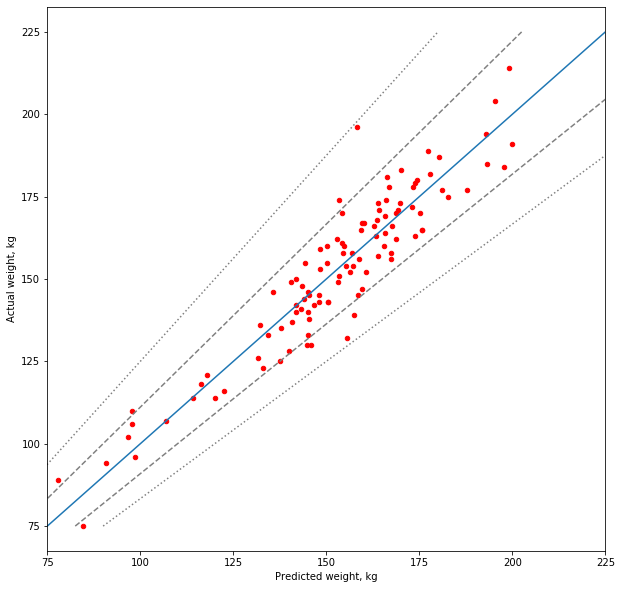

In [28]:
plt.figure(figsize=(10, 10))
y = np.arange(75,226)
x_actual = y
x_plus10 = y*1.1
x_plus20 = y*1.2
x_neg10 = y*0.9
x_neg20 = y*0.8
plt.scatter(predicted_weights, true_weights, s = 20, c='r')
#plt.plot(predicted_weights, true_weights,'ro')
plt.plot(x_actual, y)
plt.plot(x_plus10, y, color='grey', linestyle='dashed')
plt.plot(x_neg10, y, color='grey', linestyle='dashed')
plt.plot(x_plus20, y, color='grey', linestyle='dotted')
plt.plot(x_neg20, y, color='grey', linestyle='dotted')
plt.xlim(75,225)
plt.xticks(np.arange(75,230,25))
plt.yticks(np.arange(75,230,25))
plt.xlabel('Predicted weight, kg')
plt.ylabel('Actual weight, kg')

In [29]:
residuals = true_weights - predicted_weights

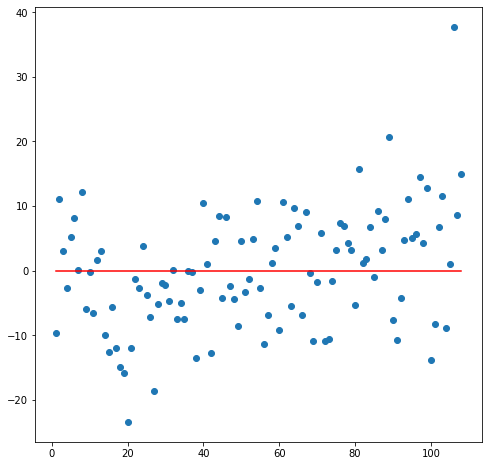

In [30]:
plt.figure(figsize=(8, 8))
x = np.arange(1,109)
y = np.zeros(108)
plt.scatter(x,residuals)
plt.plot(x,y,color='r')
plt.show()

In [31]:
MSE = np.mean(residuals**2)
print(MSE)

82.44431412924769
